# The representation of women in the cinematic industry over the years

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from scipy import stats

In [2]:
DATA_PATH = "MovieSummaries"
MOVIE_PATH = DATA_PATH + "/movie.metadata.tsv"
CHARACTER_PATH = DATA_PATH + "/character.metadata.tsv"

In [3]:
def convert_date(date_string):
    """
    Convert a date string to a pandas datetime object.

    Parameters:
    - date_string (str): The input date string to be converted.

    Returns:
    - pd.Timestamp: A pandas datetime object representing the converted date.

    Raises:
    - ValueError: If the input date string cannot be converted using any of the specified formats.
    """
    try:
        return pd.to_datetime(date_string, format='%Y-%m-%d')
    except ValueError:
        try:
            return pd.to_datetime(date_string, format='%Y-%m')
        except ValueError:
            try:
                return pd.to_datetime(date_string, format='%Y')
            except ValueError:
                return pd.to_datetime(date_string, format='%Y-%m-%d %H:%M:%S.%f')  

---

### GENERAL ANALYSIS

---

### DATA PREPROCESSING

For this analysis, we will use the files movies.metadata and characters.metadata. 

In [4]:
# Load the datasets
headers_movies = ['WikiMovieID', 
                  'FreebaseMovieID', 
                  'MovieName', 
                  'ReleaseDate', 
                  'BORevenue', 
                  'Runtime',
                  'Languages', 
                  'Countries', 
                  'MovieGenre']

headers_characters = ['WikiMovieID', 
                      'FreebaseMovieID', 
                      'ReleaseDate', 
                      'CharacterName', 
                      'DoB', 
                      'Gender', 
                      'Height', 
                      'Ethnicity', 
                      'ActorName', 
                      'Age', 
                      'FreebaseActorMapID', 
                      'FreebaseCharacterID', 
                      'FreebaseActorID']

movies = pd.read_csv(MOVIE_PATH, sep='\t', names=headers_movies)
characters = pd.read_csv(CHARACTER_PATH, sep='\t', names=headers_characters)

In [5]:
# Merge the 2 datasets according to the common columns, and drop the columns that we don't need
cmu = movies.merge(characters, how='left', on=['WikiMovieID', 'FreebaseMovieID', 'ReleaseDate'])
cmu = cmu.drop('DoB', axis=1)
cmu = cmu.drop('ActorName', axis=1)
cmu = cmu.drop('Languages', axis=1)
cmu.sample(2)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Countries,MovieGenre,CharacterName,Gender,Height,Ethnicity,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID
262649,13599177,/m/03cbhmq,Hoodoo for Voodoo,2006,NaN,80.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/03npn"": ""Horror"", ""/m/0qdzd"": ""B-movie"", ...",NaN,NaN,NaN,NaN,NaN,/m/0gcybc2,NaN,/m/0gcybc4
404167,7409519,/m/0kv6vt,Strategic Command,1997-01-06,NaN,90.0,"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03btsm8"": ""Actio...",Vice President Charles Baker,M,NaN,NaN,54.0,/m/0gcj7_z,/m/0ld3g6g,/m/0c1h8bs


In [6]:
# Keep only the rows for which we have the gender of the actor
cmu = cmu.loc[cmu['Gender'].isin(['F', 'M'])].copy(deep=True)

# The movie 'Hunting Season' has an incorrect data: 1010 instead of 2010
cmu['ReleaseDate'] = cmu['ReleaseDate'].replace('1010-12-02', '2010-12-02')
# Convert the date in the column 'ReleaseDate' into datetime
ReleaseDate_datatime = cmu['ReleaseDate'].apply(convert_date)
# Add a column with the year of release only
cmu['ReleaseYear'] = ReleaseDate_datatime.dt.year.fillna(0).astype(int)
cmu['ReleaseYear'] = cmu['ReleaseYear'].astype('int64')
cmu['ReleaseYear'].replace(0, np.nan, inplace=True)

# Convert the str-like dictionaries to dictionaries
cmu['Countries'] = cmu['Countries'].apply(ast.literal_eval)
cmu['MovieGenre'] = cmu['MovieGenre'].apply(ast.literal_eval)

# Remove outliers for age and replace null or negative values by NaN
cmu['Age'] = cmu['Age'].apply(lambda x: np.nan if x <= 0 else x)

# Drop outliers for height
Q1 = cmu['Height'].quantile(0.25)
Q3 = cmu['Height'].quantile(0.75)
IQR = Q3 - Q1
cmu = cmu[(cmu['Height'] > Q1 - 1.5 * IQR) & (cmu['Height'] < Q3 + 1.5 * IQR)]

# Drop outliers for Runtime
lower, upper = 40, 180
cmu = cmu[(cmu['Runtime'] >= lower) & (cmu['Runtime'] <= upper)]

In [7]:
cmu.sample(4)

,WikiMovieID,FreebaseMovieID,MovieName,ReleaseDate,BORevenue,Runtime,Countries,MovieGenre,CharacterName,Gender,Height,Ethnicity,Age,FreebaseActorMapID,FreebaseCharacterID,FreebaseActorID,ReleaseYear
352881,24845777,/m/09gmg1y,Start Cheering,1938,NaN,78.0,{'/m/09c7w0': 'United States of America'},"{'/m/06cvj': 'Romantic comedy', '/m/04t36': 'M...",Willie Gumbatz,M,1.70,/m/0xnvg,NaN,/m/09j42p4,/m/0h4zyc8,/m/0p9vh,1938.0
196249,146236,/m/012mrr,Close Encounters of the Third Kind,1977-11-15,337700000.0,137.0,{'/m/09c7w0': 'United States of America'},"{'/m/06n90': 'Science Fiction', '/m/07s9rl0': ...",Gillian Guiler,F,1.72,NaN,38.0,/m/03jq91b,/m/045ctvs,/m/05wk2m,1977.0
55346,2236324,/m/06y60c,Freaky Friday,2003-08-04,160846332.0,97.0,{'/m/09c7w0': 'United States of America'},"{'/m/0hqxf': 'Family Film', '/m/01hmnh': 'Fant...",Pei-Pei,F,1.67,/m/0d2by,43.0,/m/03js8ln,/m/0h5sv4x,/m/01lsq_,2003.0
26603,27693775,/m/0c3_662,The Dilemma,2011-01-13,NaN,118.0,{'/m/09c7w0': 'United States of America'},"{'/m/01t_vv': 'Comedy-drama', '/m/07s9rl0': 'D...",Beth,F,1.69,/m/041rx,40.0,/m/0c5n2yg,/m/0g4g34k,/m/0fgg4,2011.0


## AGE: IS THERE A DIFFERENCE ?

We often hear clichés about the evolution of beauty with age: women are described as blossoming in their youth, while men become more handsome with age. An intriguing question arises: does this perceived divergence in the aesthetics of aging manifest itself in the film industry, and if so, is this disparity statistically significant? 

Let's explore the data !

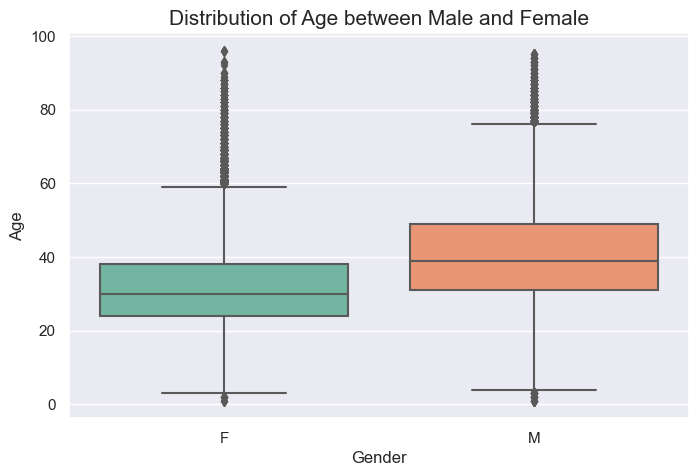

In [14]:
# Set the plot style and color palette
sns.set(style="darkgrid", palette="Set2")

plt.figure(figsize=(8, 5))

sns.boxplot(x='Gender', y='Age', data=cmu)
plt.title('Distribution of Age between Male and Female', fontsize=15)

plt.xlabel('Gender', fontsize=12)
plt.ylabel('Age', fontsize=12)

plt.show()

In [15]:
women_cmu = cmu.loc[cmu['Gender']=='F'].copy(deep=True)
men_cmu = cmu.loc[cmu['Gender']=='M'].copy(deep=True)

In [20]:
# T-test to determine if the difference in age between men and women is statistically significant 
stats.ttest_ind(women_cmu['Age'], men_cmu['Age'], nan_policy='omit')

TtestResult(statistic=-104.38345352239884, pvalue=0.0, df=124893.0)

We used a two-sided t-test for the null hypothesis that the age of actors and actresses have identical average (expected) values. The p-value is much smaller than 0.05, therefore we can reject the null hypothesis, meaning that there is a statistically significant difference in the average ages between the two groups. As the t-statistic is strongly negative (-104), it supports our conclusion that women are significantly younger than men.